In [1]:
import pandas as pd
import numpy as np
import ast
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib.patches import Ellipse, Circle
from matplotlib.lines import Line2D
import seaborn as sns

from tqdm import tqdm
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
from ipywidgets import interact, FloatSlider, IntSlider

# pd.set_option('display.max_rows', 500)
# sns.set_theme(style="whitegrid", palette="viridis")

from IPython.display import HTML
mycols = sns.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)
mycols

[(0.86, np.float64(0.3712), 0.33999999999999997),
 (np.float64(0.8287999999999999), 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, np.float64(0.3712)),
 (0.33999999999999997, np.float64(0.8287999999999999), 0.86),
 (np.float64(0.3712), 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, np.float64(0.8287999999999999))]

In [2]:
# Predefined lookup and type dictionary
grid = (11,11)
reward_place_to_coord = {
    "u": ((grid[0] // 2, grid[1] - 1),),
    "r": ((grid[0] - 1, grid[1] // 2),),
    "d": ((grid[0] // 2, 0),),
    "l": ((0, grid[1] // 2),),
    "ur": ((grid[0] // 2, grid[1] - 1), (grid[0] - 1, grid[1] // 2)),
    "rd": ((grid[0] - 1, grid[1] // 2), (grid[0] // 2, 0)),
    "dl": ((grid[0] // 2, 0), (0, grid[1] // 2)),
    "ul": ((0, grid[1] // 2), (grid[0] // 2, grid[1] - 1)),
    "ud": ((grid[0] // 2, grid[1] - 1), (grid[0] // 2, 0)),
    "rl": ((grid[0] - 1, grid[1] // 2), (0, grid[1] // 2)),
    # Note: Replace this with the updated one
}        # Mapping from reward identifiers to board coordinates.


In [3]:
def get_reward_coord(zone):
    """Return the first coordinate tuple from the lookup, or (None, None) if not found."""
    if zone in reward_place_to_coord and reward_place_to_coord[zone]:
        return reward_place_to_coord[zone][0]
    else:
        return (None, None)

In [13]:
def get_lf(strat_coln, tdf, coln="trial_id"):
    pad_size = 60
    g1x = tdf[strat_coln == "a1"].groupby(coln)["a1x"].apply(list)
    g1y = tdf[strat_coln == "a1"].groupby(coln)["a1y"].apply(list)
    lax = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1x])
    lay = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1y])
    g2x = tdf[strat_coln == "a2"].groupby(coln)["a2x"].apply(list)
    g2y = tdf[strat_coln == "a2"].groupby(coln)["a2y"].apply(list)
    lbx = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2x])
    lby = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2y])
    
    leader_trace_x = np.concatenate((lax, lbx), axis=0)
    leader_trace_y = np.concatenate((lay, lby), axis=0)

    g1x = tdf[strat_coln == "a1"].groupby(coln)["a2x"].apply(list)
    g1y = tdf[strat_coln == "a1"].groupby(coln)["a2y"].apply(list)
    lax = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1x])
    lay = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g1y])
    g2x = tdf[strat_coln == "a2"].groupby(coln)["a1x"].apply(list)
    g2y = tdf[strat_coln == "a2"].groupby(coln)["a1y"].apply(list)
    lbx = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2x])
    lby = np.array([lst + [np.nan]*(pad_size - len(lst)) for lst in g2y])
    
    follower_trace_x = np.concatenate((lax, lbx), axis=0)
    follower_trace_y = np.concatenate((lay, lby), axis=0)
    
    return leader_trace_x, leader_trace_y, follower_trace_x, follower_trace_y

In [ ]:
regime = 1
all_tdf = pd.DataFrame()

for pairs in tqdm(range(100)):
    store = f"../store_bk/{pairs}/logs/"
    stats = f"../store_bk/{pairs}/trial_stats/"
    edf = pd.read_parquet(f'{store}testing_{regime}.parquet')
    sdf = pd.read_parquet(f'{stats}testing_{regime}.parquet')
    edf["trial_id"] = edf.terminated.cumsum().shift(fill_value=0)
    sdf["rx"] = sdf["collected_zone"].apply(lambda zone: get_reward_coord(zone)[0])
    sdf["ry"] = sdf["collected_zone"].apply(lambda zone: get_reward_coord(zone)[1])
    
    t_tdf = edf.merge(sdf[['trial_id','trial_length', 'collected', 'collected_zone', "wz_cancel", 'activated_by', 'activated_frame', 'first_close_to_zone', 'first_close_to_zone_frame', 'first_to_zone', 'first_to_zone_frame', 'reward_counter', 'rx', 'ry']], on="trial_id", how="left")
    t_tdf['pair'] = pairs
    
    all_tdf = pd.concat([all_tdf, t_tdf], ignore_index=True)

# reset the index of the dataframes
all_tdf.reset_index(drop=True, inplace=True)
all_tdf['trial_id'] = all_tdf['trial_id'].astype(str) + "_" + all_tdf['pair'].astype(str)

100%|██████████| 100/100 [03:55<00:00,  2.36s/it]


In [6]:
def get_density(l1x, l1y, bins=0, sigma=1.0):
    # Drop nans from l1x, l1y for density estimation

    l1x_no_nan = l1x[~np.isnan(l1x)]
    l1y_no_nan = l1y[~np.isnan(l1y)]
    
    subsample_size = np.random.randint(0, l1x_no_nan.shape[0], 10000)
    
    l1x_no_nan = l1x_no_nan[subsample_size]
    l1y_no_nan = l1y_no_nan[subsample_size]

    values = np.vstack([l1x_no_nan, l1y_no_nan])
    kde = gaussian_kde(values)
    # Define a grid over the area of interest
    xi, yi = np.mgrid[0:11:100j, 0:11:100j]
    zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
    
    return xi, yi, zi.reshape(xi.shape)

def get_density_histogram(l1x, l1y, bins=10, sigma=1.0):
    # Remove nan values
    mask = ~np.isnan(l1x) & ~np.isnan(l1y)
    l1x_no_nan = l1x[mask]
    l1y_no_nan = l1y[mask]
    
    # Compute a 2D histogram (counts per grid cell)
    H, xedges, yedges = np.histogram2d(l1x_no_nan, l1y_no_nan, bins=bins, range=[[0, 11], [0, 11]])
    
    # Smooth the histogram with a Gaussian filter
    H_smooth = gaussian_filter(H, sigma=sigma)
    
    # Create grid for visualization (centers of the bins)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    xi, yi = np.meshgrid(xcenters, ycenters)
    
    return xi, yi, H_smooth

def plot_density(ax, xi, yi, zi, title):
    """Plot the density as a contour plot."""
    ax.contourf(xi, yi, zi, levels=25, cmap="rocket", alpha=1)
    ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 11)
    ax.set_ylim(0, 11)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, 12, 1))
    ax.set_yticks(np.arange(0, 12, 1))
    
    cbar = plt.colorbar(ax.collections[0], ax=ax, orientation='vertical')
    cbar.set_label('Density', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

def get_density_heatmap(l1x, l1y, bins=11, sigma=1.0):
    # Count the number of frequencies in a 11x11 grid
    H, xedges, yedges = np.histogram2d(l1x, l1y, bins=11, range=[[0, 11], [0, 11]])
    
    # Return unsmooothed histogram
    return xedges, yedges, H

def plot_heatmap(ax, xi, yi, zi, title):
    """Plot the heatmap as a pcolormesh."""
    c = ax.pcolormesh(xi, yi, zi.T, shading='auto', cmap='rocket')
    ax.set_xlabel('X Coordinate', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y Coordinate', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 11)
    ax.set_ylim(0, 11)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, 12, 1))
    ax.set_yticks(np.arange(0, 12, 1))
    # ax.grid(True, which='both', color='white')
    
    cbar = plt.colorbar(c, ax=ax)
    cbar.set_label('Counts', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

In [7]:
def plot_pair_pos(pair):
    l1x, l1y, f1x, f1y = get_lf(all_tdf[all_tdf.pair == pair].activated_by, all_tdf[all_tdf.pair == pair])
    l2x, l2y, f2x, f2y = get_lf(all_tdf[all_tdf.pair == pair].first_close_to_zone, all_tdf[all_tdf.pair == pair])
    l3x, l3y, f3x, f3y = get_lf(all_tdf[all_tdf.pair == pair].first_to_zone, all_tdf[all_tdf.pair == pair])
    fig, axsed = plt.subplots(4, 3, figsize=(14, 7*2), sharey=True, dpi=100)
    axs = axsed[:2, :]  # Use only the first two rows for density plots
    ax = axs[0, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density(l1x.flatten(), l1y.flatten())
    plot_density(ax[0], xi1, yi1, zi1, 'Leader is first to initiate')
    xi2, yi2, zi2 = get_density(l2x.flatten(), l2y.flatten())
    plot_density(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
    xi3, yi3, zi3 = get_density(l3x.flatten(), l3y.flatten())
    plot_density(ax[2], xi3, yi3, zi3, 'Leader is first to target')
    # plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

    ax = axs[1, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density(f1x.flatten(), f1y.flatten())
    plot_density(ax[0], xi1, yi1, zi1, '')
    xi2, yi2, zi2 = get_density(f2x.flatten(), f2y.flatten())
    plot_density(ax[1], xi2, yi2, zi2, '')
    xi3, yi3, zi3 = get_density(f3x.flatten(), f3y.flatten())
    plot_density(ax[2], xi3, yi3, zi3, '')
    # plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

    axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
    axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

    axs = axsed[2:, :]
    ax = axs[0, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density_heatmap(l1x.flatten(), l1y.flatten())
    plot_heatmap(ax[0], xi1, yi1, zi1, 'Leader is first initiate')
    xi2, yi2, zi2 = get_density_heatmap(l2x.flatten(), l2y.flatten())
    plot_heatmap(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
    xi3, yi3, zi3 = get_density_heatmap(l3x.flatten(), l3y.flatten())
    plot_heatmap(ax[2], xi3, yi3, zi3, 'Leader is first to target')
    # plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

    ax = axs[1, :]
    # Calculate and plot the density for each strategy
    xi1, yi1, zi1 = get_density_heatmap(f1x.flatten(), f1y.flatten())
    plot_heatmap(ax[0], xi1, yi1, zi1, '')
    xi2, yi2, zi2 = get_density_heatmap(f2x.flatten(), f2y.flatten())
    plot_heatmap(ax[1], xi2, yi2, zi2, '')
    xi3, yi3, zi3 = get_density_heatmap(f3x.flatten(), f3y.flatten())
    plot_heatmap(ax[2], xi3, yi3, zi3, '')
    # plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

    axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
    axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

    plt.tight_layout()
    # plt.show()
    plt.savefig(f"cache/{pair}.png", dpi=300)
    plt.close()

In [ ]:
for i in tqdm(range(100)):
    plot_pair_pos(i)

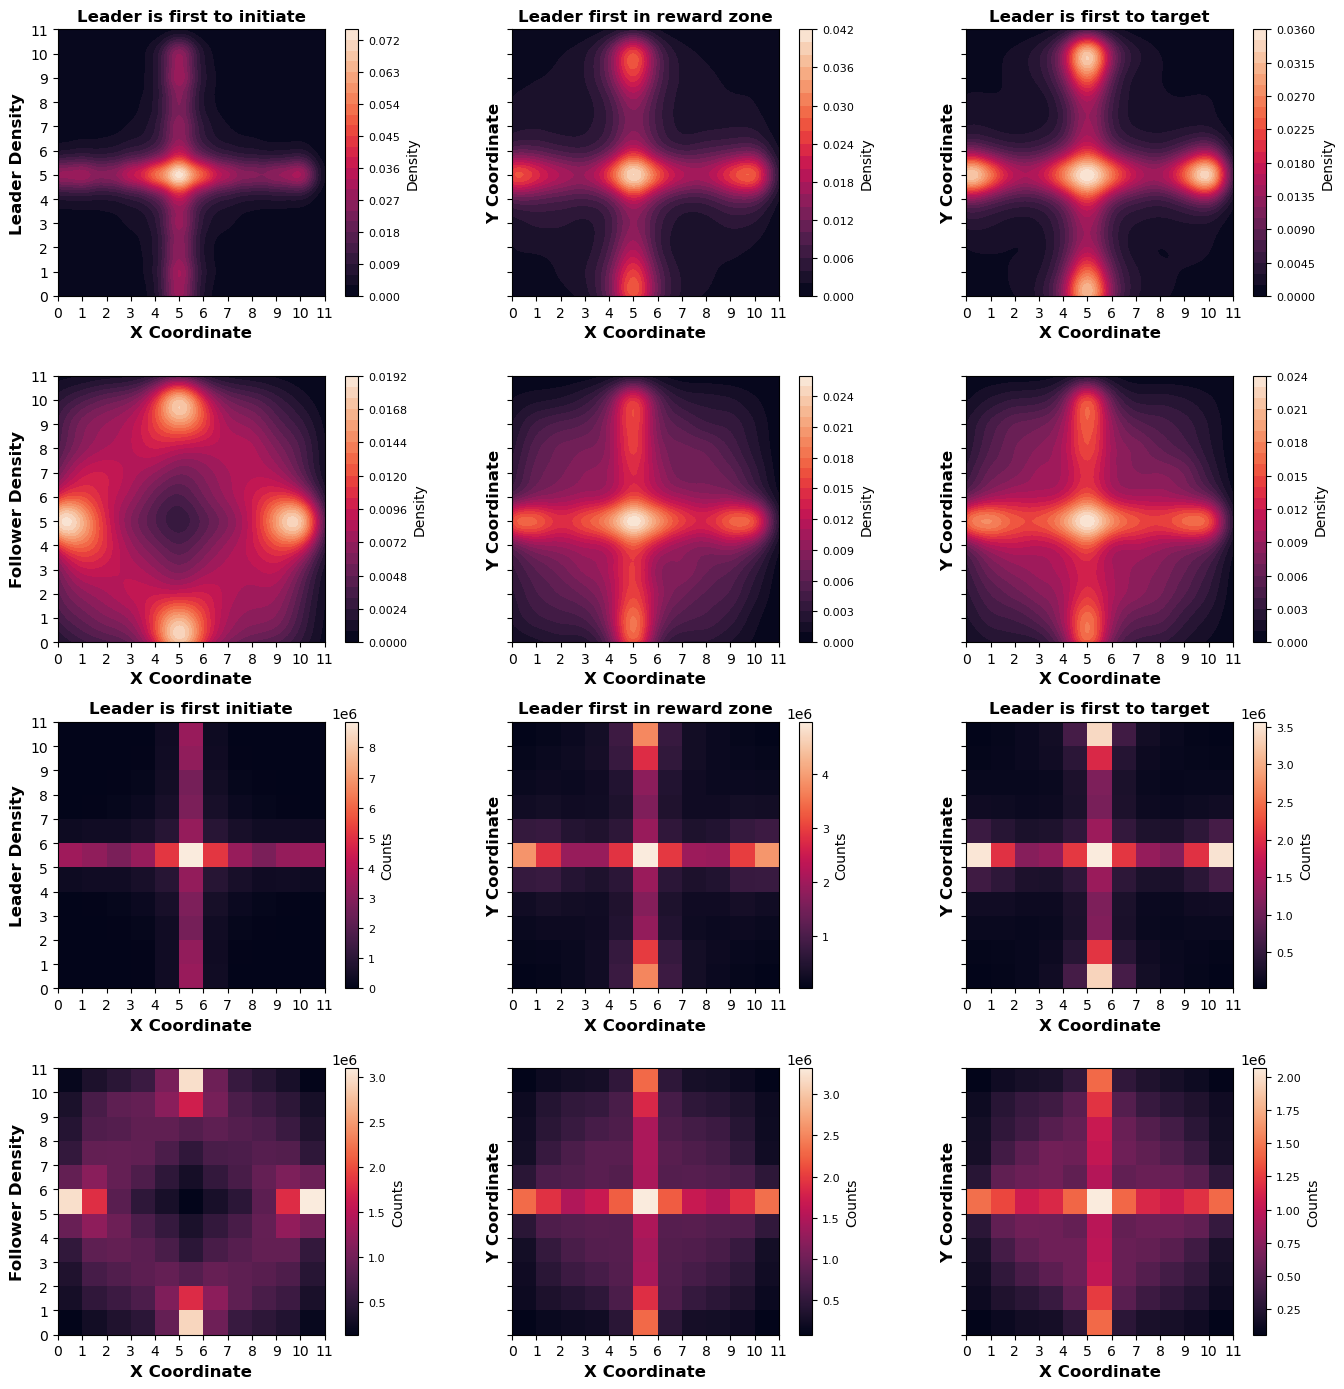

In [15]:
# total together
l1x, l1y, f1x, f1y = get_lf(all_tdf.activated_by, all_tdf)
l2x, l2y, f2x, f2y = get_lf(all_tdf.first_close_to_zone, all_tdf)
l3x, l3y, f3x, f3y = get_lf(all_tdf.first_to_zone, all_tdf)
fig, axsed = plt.subplots(4, 3, figsize=(14, 7*2), sharey=True, dpi=100)
axs = axsed[:2, :]  # Use only the first two rows for density plots
ax = axs[0, :]
# Calculate and plot the density for each strategy
xi1, yi1, zi1 = get_density(l1x.flatten(), l1y.flatten())
plot_density(ax[0], xi1, yi1, zi1, 'Leader is first to initiate')
xi2, yi2, zi2 = get_density(l2x.flatten(), l2y.flatten())
plot_density(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
xi3, yi3, zi3 = get_density(l3x.flatten(), l3y.flatten())
plot_density(ax[2], xi3, yi3, zi3, 'Leader is first to target')
# plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

ax = axs[1, :]
# Calculate and plot the density for each strategy
xi1, yi1, zi1 = get_density(f1x.flatten(), f1y.flatten())
plot_density(ax[0], xi1, yi1, zi1, '')
xi2, yi2, zi2 = get_density(f2x.flatten(), f2y.flatten())
plot_density(ax[1], xi2, yi2, zi2, '')
xi3, yi3, zi3 = get_density(f3x.flatten(), f3y.flatten())
plot_density(ax[2], xi3, yi3, zi3, '')
# plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

axs = axsed[2:, :]
ax = axs[0, :]
# Calculate and plot the density for each strategy
xi1, yi1, zi1 = get_density_heatmap(l1x.flatten(), l1y.flatten())
plot_heatmap(ax[0], xi1, yi1, zi1, 'Leader is first initiate')
xi2, yi2, zi2 = get_density_heatmap(l2x.flatten(), l2y.flatten())
plot_heatmap(ax[1], xi2, yi2, zi2, 'Leader first in reward zone')
xi3, yi3, zi3 = get_density_heatmap(l3x.flatten(), l3y.flatten())
plot_heatmap(ax[2], xi3, yi3, zi3, 'Leader is first to target')
# plt.suptitle('Evaluation - Density of Leader Positions', fontsize=14, fontweight='bold')

ax = axs[1, :]
# Calculate and plot the density for each strategy
xi1, yi1, zi1 = get_density_heatmap(f1x.flatten(), f1y.flatten())
plot_heatmap(ax[0], xi1, yi1, zi1, '')
xi2, yi2, zi2 = get_density_heatmap(f2x.flatten(), f2y.flatten())
plot_heatmap(ax[1], xi2, yi2, zi2, '')
xi3, yi3, zi3 = get_density_heatmap(f3x.flatten(), f3y.flatten())
plot_heatmap(ax[2], xi3, yi3, zi3, '')
# plt.suptitle('Evaluation - Density of Follower Positions', fontsize=14, fontweight='bold')

axs[0,0].set_ylabel('Leader Density', fontsize=12, fontweight='bold')
axs[1,0].set_ylabel('Follower Density', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()